In [1]:
from tensorflow import keras
from keras.layers import (
    Input,
    Add,
    Dense,
    Activation,
    ZeroPadding2D,
    BatchNormalization,
    Flatten,
    Conv2D,
    AveragePooling2D,
    MaxPooling2D,
)
from keras.models import Model
import tensorflow as tf
from tensorflow.python.keras import layers
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
import pickle
import numpy as np
import json
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
(X_train, y_train),(X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train = X_train / 255.0
X_test = X_test / 255.0

X_train = X_train.reshape(X_train.shape[0],28,28,1)
X_test = X_test.reshape(X_test.shape[0],28,28,1)

4422102/4422102 [==============================] - 1s 0us/step


In [3]:
class ResNet18:
  def __init__(self, num_classes = 10, input_shape = (None, None, 3), **kwargs):
    self.num_classes = num_classes
    self.input_shape = input_shape

  def identity_block18(self, x, filter):

    x_skip = x

    x = keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = keras.layers.BatchNormalization(axis=3)(x)
    x = layers.Lambda(lambda x: tf.keras.activations.relu(x))(x)

    x = keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = keras.layers.BatchNormalization(axis=3)(x)

    x = keras.layers.Add()([x, x_skip])
    x = layers.Lambda(lambda x: tf.keras.activations.relu(x))(x)
    return x

  def convolutional_block18(self, x, filter):

    x_skip = x

    x = keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = keras.layers.BatchNormalization(axis=3)(x)
    x = layers.Lambda(lambda x: tf.keras.activations.relu(x))(x)

    x = keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = keras.layers.BatchNormalization(axis=3)(x)

    x_skip = keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)

    x = keras.layers.Add()([x, x_skip])
    x = layers.Lambda(lambda x: tf.keras.activations.relu(x))(x)
    return x

  def build(self, **kwargs):

    x_input = Input(self.input_shape)
    x = ZeroPadding2D((3, 3))(x_input)


    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = layers.Lambda(lambda x: tf.keras.activations.relu(x))(x)
    x = keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)


    name = "ResNet18"
    block_layers = [2, 2, 2, 2]
    filter_size = 64


    for i in range(4):
        if i == 0:
            for j in range(block_layers[i]):
                x = self.identity_block18(x, filter_size)
        else:
            filter_size = filter_size*2
            x = self.convolutional_block18(x, filter_size )
            for j in range(block_layers[i] - 1):
                x = self.identity_block18(x, filter_size)

    x = AveragePooling2D((2,2), padding = 'same')(x)
    x = Flatten()(x)
    x = Dense(self.num_classes, activation = 'softmax')(x)
    model = Model(inputs = x_input, outputs = x, name = name)

    return model

In [6]:
rn = ResNet18(input_shape=(28, 28, 1))
model = rn.build()
model.summary()

Model: "ResNet18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 zero_padding2d_1 (ZeroPadd  (None, 34, 34, 1)            0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv2d_20 (Conv2D)          (None, 17, 17, 64)           3200      ['zero_padding2d_1[0][0]']    
                                                                                                  
 batch_normalization_17 (Ba  (None, 17, 17, 64)           256       ['conv2d_20[0][0]']    

In [7]:
model.compile(
    optimizer="Adam",

    loss="sparse_categorical_crossentropy",

    metrics=["sparse_categorical_accuracy"],
)

learning = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=30, verbose=1
)


Epoch 1/30
1875/1875 [==============================] - 59s 23ms/step - loss: 0.4365 - sparse_categorical_accuracy: 0.8414 - val_loss: 0.3753 - val_sparse_categorical_accuracy: 0.8493
Epoch 2/30
1875/1875 [==============================] - 42s 22ms/step - loss: 0.3005 - sparse_categorical_accuracy: 0.8906 - val_loss: 0.3042 - val_sparse_categorical_accuracy: 0.8880
Epoch 3/30
1875/1875 [==============================] - 42s 23ms/step - loss: 0.2625 - sparse_categorical_accuracy: 0.9043 - val_loss: 0.2623 - val_sparse_categorical_accuracy: 0.9053
Epoch 4/30
1875/1875 [==============================] - 41s 22ms/step - loss: 0.2433 - sparse_categorical_accuracy: 0.9112 - val_loss: 0.3160 - val_sparse_categorical_accuracy: 0.8811
Epoch 5/30
1875/1875 [==============================] - 42s 23ms/step - loss: 0.2137 - sparse_categorical_accuracy: 0.9204 - val_loss: 0.2922 - val_sparse_categorical_accuracy: 0.8936
Epoch 6/30
1875/1875 [==============================] - 41s 22ms/step - loss: 0.

In [8]:
loss_train = learning.history["loss"]

loss_val = learning.history["val_loss"]

acc_train = learning.history["sparse_categorical_accuracy"]

acc_val = learning.history["val_sparse_categorical_accuracy"]

y_pred = [np.argmax(arr) for arr in model.predict(X_test)]

prf_score = precision_recall_fscore_support(y_test, y_pred, average="weighted")

score = model.evaluate(X_test, y_test)

313/313 [==============================] - 3s 10ms/step - loss: 0.4889 - sparse_categorical_accuracy: 0.9133


In [20]:
with open("/content/drive/My Drive/Colab Notebooks/trained_model/resnet18_relu_fmnist", 'wb') as f:
  pickle.dump(model, f)

In [21]:
with open("/content/drive/My Drive/Colab Notebooks/trained_model/resnet18_relu_fmnist", 'rb') as f:
  model = pickle.load(f)

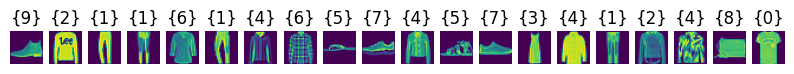

In [29]:
plt.figure(figsize=(10, 10))
for i in range(20):
    plt.subplot(1, 20, i+1)
    plt.imshow(X_test[i])
    plt.title({y_test[i]})
    plt.axis('off')
plt.show()

In [30]:
print([np.argmax(arr) for arr in model.predict(X_test[0:20])])


1/1 [==============================] - 1s 547ms/step
[9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 6, 8, 0]
